## Fourier Neural Operator 1D

In [1]:
## Imports 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import torch.nn as nn
from timeit import default_timer

c:\Users\s1612415\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Set seeds
torch.manual_seed(0)
np.random.seed(0)

## Create Data

### Ordinary Differential Equation:

\begin{align*}
m\frac{d^2x}{dt^2} = - kx
\end{align*}

Solution: 
$$x(t) = x_0 \cos{\left(\sqrt{\frac{k}{m}}t\right)} + \frac{v_0}{\sqrt{\frac{k}{m}}}\sin{\left(\sqrt{\frac{k}{m}}t\right)}$$

In [3]:
## TODO: Create Simple Harmonic Oscillator Class

In [4]:
## Simple Harmonic Oscillator
def simple_harmonic_oscillator(k: int, m: int, x0: int, v0: int, t: np.array) -> np.array:
    x = x0 * np.cos(np.sqrt(k / m) * t) + v0 / np.sqrt(k / m) * np.sin(np.sqrt(k / m) * t)
    return x    

In [5]:
## Number of Samples 
n = 1000
## Output
# data_t = []
t = np.linspace(0, 100, 100)
data_x = []

## Generate Data
for _ in range(n):
    k = np.random.randint(1, 100)
    m = np.random.randint(1, 100)
    x0 = np.random.normal(0, 10)
    v0 = np.random.normal(0, 10)
    # t = np.linspace(0, 100, 100) ## Can change resolution
    
    # data_t.append(t)
    data_x.append(simple_harmonic_oscillator(k, m, x0, v0, t))

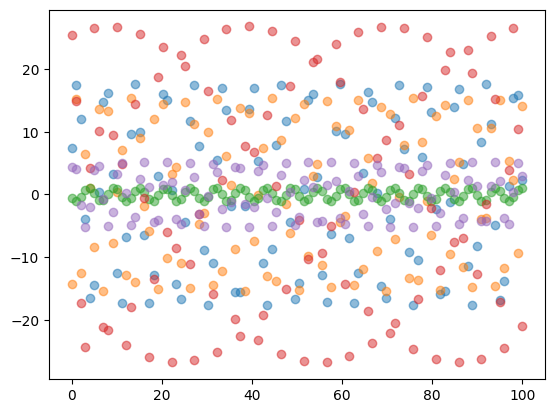

In [6]:
## Plot 5 Samples
for i in range(5):
    # plt.scatter(data_t[i], data_x[i], alpha=0.5)
    plt.scatter(t, data_x[i], alpha=0.5)
plt.show()

In [7]:
## Change data_t from np.array to torch.Tensor
# data_t = [torch.from_numpy(data_t[i]).float() for i in range(n)]
## Change data_t from torch.Size([100]) to torch.Size([1, 100])
# data_t = [data_t[i].unsqueeze(0).unsqueeze(0) for i in range(n)]

t = torch.from_numpy(t).float().unsqueeze(0).unsqueeze(0)

## Change data_x from np.array to torch.Tensor
data_x = [torch.from_numpy(data_x[i]).float() for i in range(n)]
## Change data_x from torch.Size([100]) to torch.Size([1, 100])
data_x = [data_x[i].unsqueeze(0).unsqueeze(0) for i in range(n)]

## Build Network

In [8]:
## Get Device for Training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.')

Using cpu device.


In [9]:
## Fourier Integral Kernel 1D
class FourierIntegralKernel1D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super(FourierIntegralKernel1D, self).__init__()
        '''
        '''
        self.in_channels = in_channels
        self.out_channels = out_channels 
        self.modes = modes 
        ## Set (random) weights for the linear transform
        weights = torch.rand(self.modes, self.out_channels, self.in_channels, dtype=torch.cfloat) 
        self.weights = nn.Parameter(weights / (self.in_channels * self.out_channels)) ## Optional: Scale weights

    def forward(self, v: torch.Tensor) -> torch.Tensor:
        '''
        FFT -> Linear Transform -> Inverse FFT
        '''
        ## FFT
        v_rfft = torch.fft.rfft(v) 

        ## Linear Transform 
        lv_rfft = torch.zeros(v_rfft.shape, dtype=torch.cfloat)
        lv_rfft[:, :, :self.modes] = torch.einsum('koi, bil -> bol', self.weights, v_rfft[:, :, :self.modes])
        
        ## Inverse FFT
        v2 = torch.fft.irfft(lv_rfft, n=v.shape[-1])
        return v2
        

In [10]:
## Fourier Network Operator 1D
class FourierNetworkOperator1D(nn.Module):
    def __init__(self, da: int, du: int, width: int, modes: int):
        super(FourierNetworkOperator1D, self).__init__()
        '''
        '''
        self.width = width
        self.modes = modes

        ## P: Lifts the lower dimensional function to higher dimensional space
        self.P = nn.Conv1d(da, self.width, 1) ## TODO: Change da

        ## K: Fourier integral kernel operator
        self.k0 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k1 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k2 = FourierIntegralKernel1D(self.width, self.width, self.modes)
        self.k3 = FourierIntegralKernel1D(self.width, self.width, self.modes)

        ## W: Pointwise linear operator
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        ## Q: Projects the higher dimensional function to lower dimensional space
        self.Q = nn.Conv1d(self.width, du, 1) ## TODO: Change du

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        '''
        ## P
        x = self.P(x)

        ## Fourier Layer #0
        ## K
        x1 = self.k0(x)
        ## W
        x2 = self.w0(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)

        ## Fourier Layer #1
        ## K
        x1 = self.k1(x)
        ## W
        x2 = self.w1(x)
        ## Sum 
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)

        ## Fourier Layer #2
        ## K
        x1 = self.k2(x)
        ## W
        x2 = self.w2(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)

        ## Fourier Layer #3
        ## K
        x1 = self.k3(x)
        ## W
        x2 = self.w3(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        
        ## Q
        x = self.Q(x)
        return x


In [11]:
import operator
from functools import reduce

def count_parameters(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size() + (2, ) if p.is_complex() else p.size()))
    return c

model = FourierNetworkOperator1D(1, 1, width=64, modes=16)
print(f'Number of parameters: {count_parameters(model)}')

Number of parameters: 541121


## Train

In [ ]:
## Model Parameters

In [15]:
## Model Parameters
batch_size = 16
epochs = 20

learning_rate = 1e-3
learning_rate_decay = 0.5


In [ ]:
## Optimizer 

In [16]:
## Optimizer
from torch import optim
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0, 5, 10, 15], gamma=learning_rate_decay)

In [ ]:
## Loss Function

In [17]:
#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

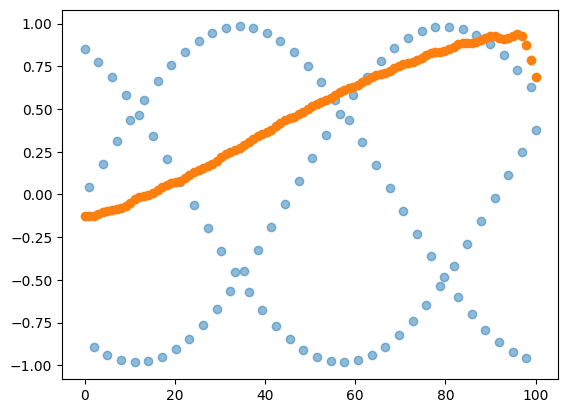

In [13]:
## Test
k = np.random.randint(1, 100)
m = np.random.randint(1, 100)
x0 = np.random.normal(0, 10)
v0 = np.random.normal(0, 10)
x_test = simple_harmonic_oscillator(k, m, x0, v0, t)

plt.scatter(t, x_test, alpha=0.5)
plt.scatter(t, model(t).detach())
plt.show()

In [ ]:
## Training Loop

In [19]:
## Training Loop
myLoss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for i in range(n):
        t = data_t[i]
        x = data_x[i]
        
        optimizer.zero_grad()
        x_pred = model(t)

        mse = nn.functional.mse_loss(x_pred, x)
        l2 = myLoss(x_pred, x)
        l2.backward()

        optimizer.step()
        scheduler.step()
        train_mse += mse.item()
        train_l2 += l2.item()
    
    model.eval()

    train_mse /= n
    train_l2 /= n

    t2 = default_timer()
    print(f'Epoch: {ep}, MSE: {train_mse:.6f}, L2: {train_l2:.6f}, Time: {t2-t1:.2f}')
    

Epoch: 0, MSE: 224.567958, L2: 1.006317, Time: 8.14
Epoch: 1, MSE: 224.523652, L2: 1.000187, Time: 8.76
Epoch: 2, MSE: 224.527601, L2: 1.000217, Time: 8.69
Epoch: 3, MSE: 224.517644, L2: 1.000197, Time: 9.04
Epoch: 4, MSE: 224.532764, L2: 1.000226, Time: 10.31
Epoch: 5, MSE: 224.517408, L2: 1.000041, Time: 10.39
Epoch: 6, MSE: 224.515431, L2: 1.000038, Time: 10.61
Epoch: 7, MSE: 224.512061, L2: 1.000049, Time: 9.89
Epoch: 8, MSE: 224.516357, L2: 1.000052, Time: 10.63
Epoch: 9, MSE: 224.519302, L2: 1.000037, Time: 10.98
Epoch: 10, MSE: 224.518262, L2: 1.000052, Time: 10.79
Epoch: 11, MSE: 224.519138, L2: 1.000038, Time: 11.31
Epoch: 12, MSE: 224.516291, L2: 1.000033, Time: 10.95
Epoch: 13, MSE: 224.515441, L2: 1.000031, Time: 10.94
Epoch: 14, MSE: 224.507676, L2: 1.000045, Time: 11.15


KeyboardInterrupt: 

## Test

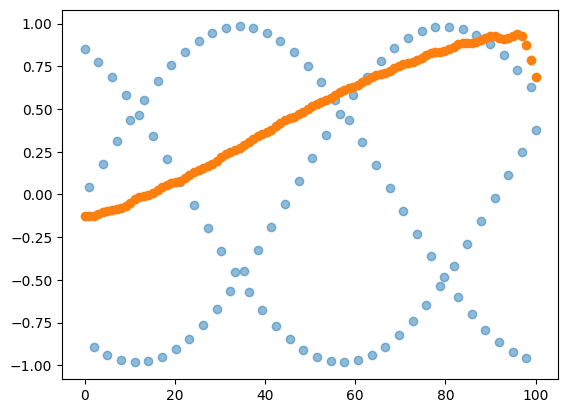

In [14]:
## Test
# k = np.random.randint(1, 100)
# m = np.random.randint(1, 100)
# x0 = np.random.normal(0, 10)
# v0 = np.random.normal(0, 10)
# x_test = simple_harmonic_oscillator(k, m, x0, v0, t_test)

plt.scatter(t, x_test, alpha=0.5)
plt.scatter(t, model(t).detach())
plt.show()